In [1]:

import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=3, cores=3) #
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.33:8787/status,
Dashboard: http://10.148.0.33:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.33:58658,Workers: 0
Dashboard: http://10.148.0.33:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Using indices : 

In [39]:
# All faces
grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]

depth = grid.Depth.isel(i=slice(0,None,4), j=slice(0,None,4))
depth = depth.where(depth>0)

#(depth
# .plot(col='face', col_wrap=5)
#)

/dev/shm/pbs.425373.datarmor0/ipykernel_4012/1494207922.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


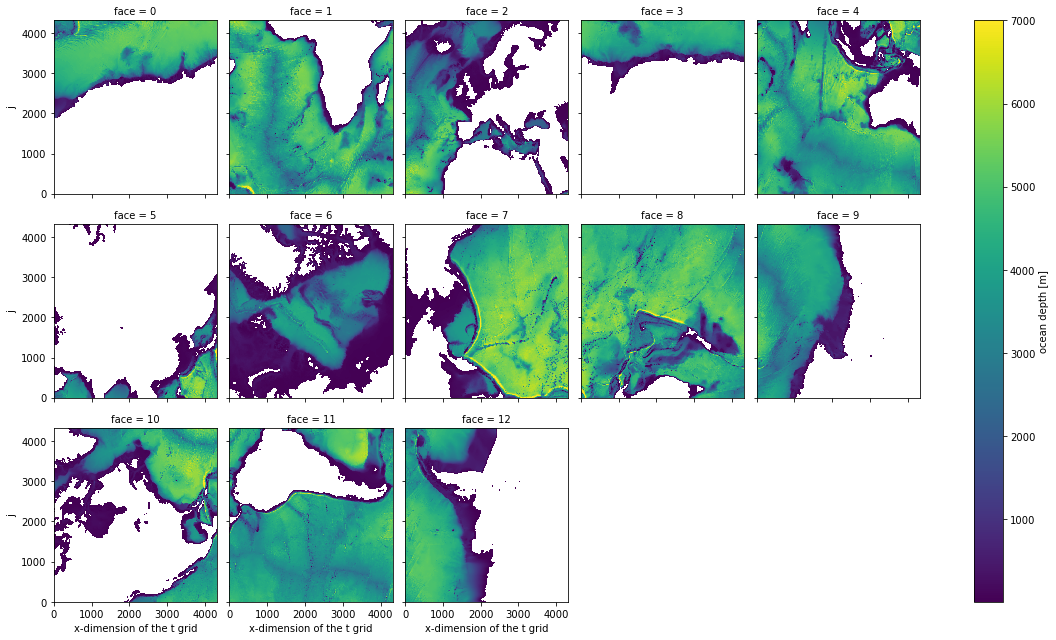

In [5]:
(depth
 .plot(col='face', col_wrap=5)
)

In [12]:
isel = dict(face=10)
sel = dict(i=slice(2700,3500),j=slice(0,600)) #California
#isel = dict(face=2)
#sel = dict(i=slice(1500, 2200),j=slice(1000, 2000))
#isel = dict(face=1)
#sel = dict(i=slice(0, 1500),j=slice(3500, None)) #Equator (atlantic)
#isel = dict(face=2, i=slice(1500, 2200), j=slice(1000, 2000), i_g=slice(1500, 2200), j_g=slice(1000, 2000)) # Mediterranean sea
#isel = dict(face=4)
#sel = dict(i=slice(3000, 4000), j=slice(2000, 3500)) # North West Australia
#isel = dict(face=7)
#sel = dict(i=slice(2500, 3500), j=slice(2500, 3500), i_g=slice(2500, 3500), j_g=slice(2500, 3500)) # North East Hawaii

isel = dict(face=11)
sel = dict(i=slice(0,2500),j=slice(0,2500)) 

isel = dict(face=8)
sel = dict(j=slice(2000,None),i=slice(0,4000)) 

In [13]:
ds_low = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_lpass_filtered_mean0.zarr') #filtered dataset
ds_hf = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_bandpassed_filtered.zarr') #filtered dataset
ds_raw = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr') # original dataset

grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]

ds_low = ds_low.isel(**isel).sel(**sel)
ds_hf = ds_hf.isel(**isel).sel(**sel)
ds_raw = ds_raw.isel(**isel).sel(**sel)
grd = grid.isel(**isel).sel(**sel)
#ds = xr.merge([ds, grd])

/dev/shm/pbs.763166.datarmor0/ipykernel_21270/3918290033.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_raw = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr') # original dataset
/dev/shm/pbs.763166.datarmor0/ipykernel_21270/3918290033.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store w

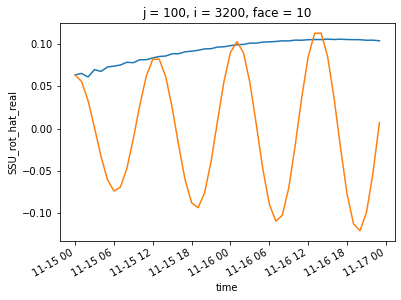

In [15]:
ds.SSU_rot_demodulated_real.sel(i=3200,j=100).isel(time=slice(0,48)).plot()
ds.SSU_rot_hat_real.sel(i=3200,j=100).isel(time=slice(0,48)).plot()

In [14]:
ds_hf = ds_hf.drop(['SSU_rot_demodulated_real','SSU_rot_demodulated_imag','SSU_rot_hat_real','SSU_rot_hat_imag'])

In [37]:
#ds['SSU_rot_demodulated'] = ds['SSU_rot_demodulated_real']+1j*ds['SSU_rot_demodulated_imag']
ds['variance'] = (np.abs(ds.SSU_rot_demodulated)**2).mean('time')

In [28]:
ds = ds.chunk({'i':128,'j':128})

In [15]:
#sli = 4
#ds = ds.isel(i = slice(0,None,sli), j = slice(0,None,sli), i_g = slice(0,None,sli), j_g = slice(0,None,sli))
ds_low['lon'] = 0*ds_low.face+grd.XC
ds_low['lat'] = 0*ds_low.face+grd.YC

ds_hf['lon'] = 0*ds_hf.face+grd.XC
ds_hf['lat'] = 0*ds_hf.face+grd.YC

ds_raw['lon'] = 0*ds_raw.face+ds_raw.XC
ds_raw['lat'] = 0*ds_raw.face+ds_raw.YC

In [9]:
ds_low.lon.min().compute()

<xarray.DataArray 'lon' ()>
array(-176.32292175)
Coordinates:
    face     int64 8

In [16]:
#bbox = [-30,-15,0,10]
#bbox = [-130, -120, 35, 40] # california [-130,-118,30,40]
#bbox = [-2, 8, 36, 45] # mediterranean sea
#bbox = [120, 126, -20, -10] # North-west Australia
#bbox = [-162, -157, 33, 37] # North-east Hawaii
#bbox = [-120,-80,0,10] # Amérique centrale
bbox = [-170,-130,-20,-10] # Polynésie

In [17]:
print(ds_low.lat.max().compute())
print(ds_low.lat.min().compute())

print(ds_low.lon.max().compute())
print(ds_low.lon.min().compute())

<xarray.DataArray 'lat' ()>
array(13.72816563)
Coordinates:
    face     int64 8
<xarray.DataArray 'lat' ()>
array(-53.36187744)
Coordinates:
    face     int64 8
<xarray.DataArray 'lon' ()>
array(-128.07292175)
Coordinates:
    face     int64 8
<xarray.DataArray 'lon' ()>
array(-176.32292175)
Coordinates:
    face     int64 8


In [44]:
#ds_sub = ds[['SSU_rot_demodulated_real','SSU_rot_demodulated_imag','SSU_rot_demodulated','lon','lat']]#,'XC','YC','Depth'
ds_sub = ds
ds_sub

<xarray.Dataset>
Dimensions:      (j: 205, i: 376, time: 2880)
Coordinates:
  * j            (j) int64 3500 3504 3508 3512 3516 ... 4300 4304 4308 4312 4316
  * i            (i) int64 0 4 8 12 16 20 24 ... 1480 1484 1488 1492 1496 1500
    face         int64 1
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSV_rot_hat  (j, i, time) float64 dask.array<chunksize=(25, 100, 2880), meta=np.ndarray>
    lon          (j, i) float64 dask.array<chunksize=(205, 270), meta=np.ndarray>
    lat          (j, i) float64 dask.array<chunksize=(205, 270), meta=np.ndarray>

In [18]:
ds_raw = ds_raw.isel(time=slice(0,None,3),i=slice(0,None,4),j=slice(0,None,4))
ds_hf = ds_hf.isel(time=slice(0,None,3),i=slice(0,None,4),j=slice(0,None,4))

In [19]:
ds_raw_sub = ds_raw[['SSU_rot','lon','lat','XC','YC','Depth']].where((ds_raw.lat<=bbox[3]) & (ds_raw.lat>=bbox[2])& 
                                                                     (ds_raw.lon>=bbox[0]) & (ds_raw.lon<=bbox[1])
                                                                     ,drop=True).persist()#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


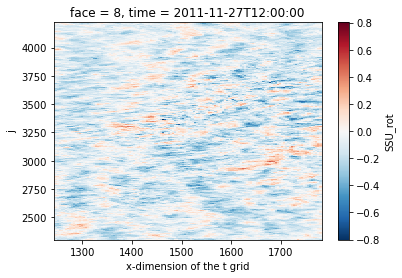

In [20]:
ds_raw_sub.SSU_rot.isel(time=100).plot()

In [21]:
ds_low_sub = ds_low.where((ds_low.lat<=bbox[3]) & (ds_low.lat>=bbox[2])& (ds_low.lon>=bbox[0]) & (ds_low.lon<=bbox[1]),drop=True).persist()#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


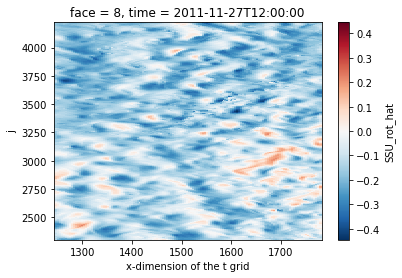

In [22]:
ds_low_sub.SSU_rot_hat.isel(time=100).plot()

In [23]:
ds_hf_sub = ds_hf.where((ds_hf.lat<=bbox[3]) & (ds_hf.lat>=bbox[2])& (ds_hf.lon>=bbox[0]) & (ds_hf.lon<=bbox[1]),drop=True).persist()#

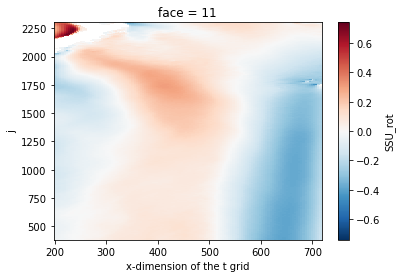

In [40]:
ds_raw_sub.SSU_rot.mean('time').plot()

In [24]:
ds_raw#low_sub

<xarray.Dataset>
Dimensions:  (j: 601, i: 801, time: 8640)
Coordinates:
    face     int64 10
  * i        (i) int64 2700 2701 2702 2703 2704 ... 3496 3497 3498 3499 3500
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599 600
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    CS       (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    SSU_rot  (time, j, i) float32 dask.array<chunksize=(240, 192, 180), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(601, 540), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(601, 540), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(601, 540), meta=np.ndarray>

In [27]:
i0,j0 = 3000,150
dsi_raw = ds_raw_sub.sel(i=i0,j=j0,method='nearest')
dsi_low = ds_low_sub.sel(i=i0,j=j0,method='nearest')
dsi_hf = ds_hf_sub.sel(i=i0,j=j0,method='nearest')

In [21]:
dsi_low

<xarray.Dataset>
Dimensions:      (time: 2880)
Coordinates:
    j            int64 152
    i            int64 3000
    face         int64 10
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSU_rot_hat  (time) float64 dask.array<chunksize=(2880,), meta=np.ndarray>
    lon          float64 dask.array<chunksize=(), meta=np.ndarray>
    lat          float64 dask.array<chunksize=(), meta=np.ndarray>

(15400.0, 15492.0)

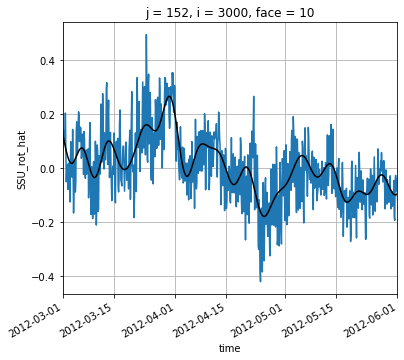

In [34]:
fig,ax = plt.subplots(figsize=(6,5))
dsi_raw.SSU_rot.isel(time=slice(int(100*24/3),int(200*24/3))).plot(ax=ax,label='Raw signal')
dsi_low.SSU_rot_hat.isel(time=slice(int(100*24/3),int(200*24/3))).plot(ax=ax,c='k',label='Raw signal')
ax.grid();ax.set_xlim('2012-03-01','2012-06-01')
ax.set_title(-
#dsi_hf.SSU_rot_demodulated.real.plot(ax=ax)

In [99]:
ds_sub['variance'] = (np.abs(ds_sub.SSU_rot_demodulated)**2).mean('time')
ds_sub = ds_sub.persist()

In [21]:
ds_sub.SSU_rot_hat

<xarray.DataArray 'SSU_rot_hat' (j: 131, i: 180, time: 2880)>
dask.array<where, shape=(131, 180, 2880), dtype=float64, chunksize=(100, 100, 2880), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 3600 3604 3608 3612 3616 ... 4104 4108 4112 4116 4120
  * i        (i) int64 384 388 392 396 400 404 ... 1080 1084 1088 1092 1096 1100
    face     int64 1
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00

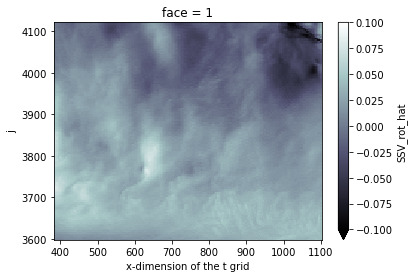

In [49]:
ds_sub.SSV_rot_hat.mean('time').plot(cmap='bone',vmax=0.1)

In [50]:
ds_raw_sub = ds_raw_sub.where((ds_raw_sub.lat<=bbox[3]) & (ds_raw_sub.lat>=bbox[2]),drop=True).persist()#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [51]:
ds_raw_sub = ds_raw_sub.where((ds_raw_sub.lon>=bbox[0])& (ds_raw_sub.lon<=bbox[1]),drop=True).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [24]:
# define target chunks
chunks_new = dict(time=1024, i=128, j=128) # 512, 256, 256 may have been a better choice
#chunks_new["i_g"] = chunks_new["i"]
#chunks_new["j_g"] = chunks_new["j"]

ds_low_sub = ds_low_sub.chunk(chunks_new).persist()
ds_hf_sub = ds_hf_sub.chunk(chunks_new).persist()
ds_raw_sub = ds_raw_sub.chunk(chunks_new).persist()

In [33]:
ds_low_sub

<xarray.Dataset>
Dimensions:      (j: 120, i: 159, time: 2880)
Coordinates:
  * j            (j) int64 0 4 8 12 16 20 24 28 ... 452 456 460 464 468 472 476
  * i            (i) int64 2768 2772 2776 2780 2784 ... 3384 3388 3392 3396 3400
    face         int64 10
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSU_rot_hat  (j, i, time) float64 dask.array<chunksize=(120, 128, 1024), meta=np.ndarray>
    lon          (j, i) float64 dask.array<chunksize=(120, 128), meta=np.ndarray>
    lat          (j, i) float64 dask.array<chunksize=(120, 128), meta=np.ndarray>

In [42]:
ds_raw_sub['SSU_rot'] = ds_raw_sub['SSU_rot'].transpose('j','i','time')

In [15]:
ds = xr.merge([ds_raw_sub,ds_low_sub.rename({'SSU_rot_hat':'SSU_rot_hat_low'}).drop(['lon','lat']),ds_hf_sub.drop(['lon','lat'])
              ]).persist()

In [34]:
import os
out_dir = os.path.join("/home1/datawork/zcaspar/mit4320/", "regional_poly")
llc_zarr_filt = os.path.join(out_dir, "llc_SSU_bfiltered.zarr")
llc_zarr_lfilt = os.path.join(out_dir, "llc_SSU_lfiltered.zarr")
llc_zarr = os.path.join(out_dir, "llc_SSU.zarr")




In [17]:
ds = ds.unify_chunks().persist()

In [18]:
print(ds.SSU_rot.T.shape,ds.SSU_rot_hat.shape)

(2880, 81, 96) (96, 81, 2880)


In [42]:
ds['lat'] = ds.lat.chunk({'i': 128,'j':128})#.chunks
ds['lon'] = ds.lat.chunk({'i': 128,'j':128})#.chunks

ds['YC'] = ds.XC.chunk({'i': 128,'j':128})#.chunks
ds['XC'] = ds.YC.chunk({'i': 128,'j':128})#.chunks
ds['Depth'] = ds.Depth.chunk({'i': 128,'j':128})#.chunks
ds['SSU_rot_hat_low'] = ds.SSU_rot_hat_low.chunk({'time':-1,'i': 128,'j':128})#.chunks
ds['SSU_rot_hat'] = ds.SSU_rot_hat.chunk({'time':-1,'i': 128,'j':128})#.chunks
ds['SSU_rot_demodulated'] = ds.SSU_rot_demodulated.chunk({'time':-1,'i': 128,'j':128})#.chunks
ds['SSU_rot'] = ds.SSU_rot.chunk({'time':-1,'i': 128,'j':128})#.chunks

In [26]:
ds_raw_sub.to_zarr(llc_zarr, mode="w")

In [27]:
ds_hf_sub.to_zarr(llc_zarr_filt, mode="w")

In [28]:
ds_low_sub.to_zarr(llc_zarr_lfilt, mode="w")

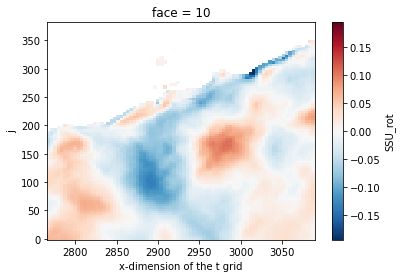

In [21]:
ds.SSU_rot.mean('time').plot()

#### Lagrangian data

In [29]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
#parcels_index = 'time'
parcels_index_hf = 'filtered_itide_Tw30_sd_band04'
parcels_index = 'lpass_filtered_05cpd'
# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index_hf])
df_hf = p[parcels_index_hf]
df_hf = pa.degs2ms(df_hf)

In [30]:
import os
#bbox = [-130, -120, 35, 40] # california
#bbox = [-2, 8, 36, 45] # mediterranean sea
#bbox = [120, 126, -20, -10] # North-west Australia
#bbox=[-30,-15,0,10]
parcels_name = "llc_parcels_"+parcels_index
parcels_name_hf = "llc_parcels_"+parcels_index_hf
parcels_path = os.path.join(out_dir, parcels_name)
parcels_path_hf = os.path.join(out_dir, parcels_name_hf)

In [31]:
# extract relevant trajectory indices
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
_df = _df.drop_duplicates(subset=["trajectory"]).compute()
traj = _df["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

In [32]:
# extract relevant trajectory indices
df_selected_hf = df_hf[df_hf.trajectory.isin(traj)]

In [15]:
lon,lat = _df.lon.values,_df.lat.values#.compute()

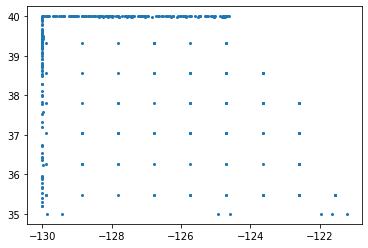

In [16]:
plt.scatter(lon,lat,s=4)

In [71]:
_df.groupby('trajectory').count().lat.max()#get_group(6000285)

1

In [51]:
df_selected_hf

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
npartitions=935,,,,,,,,,,,,,,,
2011-11-15 00:00:00,int64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
2011-11-15 03:00:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 00:00:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 01:00:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [30]:
df_selected = df_selected.rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'
                            ,'Eta_interp':'sea_level_mean','SSS_interp':'salinity_mean','SST_interp':'temperature_mean'})

In [31]:
df_selected

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean
npartitions=749,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

No reindexing
deleting existing archive: /home/datawork-lops-osi/equinox/mit4320/diags/regional_cali/llc_parcels_lpass_filtered_05cpd
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/regional_cali/llc_parcels_lpass_filtered_05cpd


'/home/datawork-lops-osi/equinox/mit4320/diags/regional_cali/llc_parcels_lpass_filtered_05cpd'

In [35]:
pa.store_parquet(out_dir, df_selected_hf, name=parcels_name_hf, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/zcaspar/mit4320/regional_poly/llc_parcels_filtered_itide_Tw30_sd_band04
create new archive: /home1/datawork/zcaspar/mit4320/regional_poly/llc_parcels_filtered_itide_Tw30_sd_band04


'/home1/datawork/zcaspar/mit4320/regional_poly/llc_parcels_filtered_itide_Tw30_sd_band04'

### Load data

In [97]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_cal")
llc_zarr = os.path.join(out_dir, "llc.zarr")
ds = xr.open_zarr(llc_zarr)

In [98]:
ds_mean = ds.mean('time').compute()

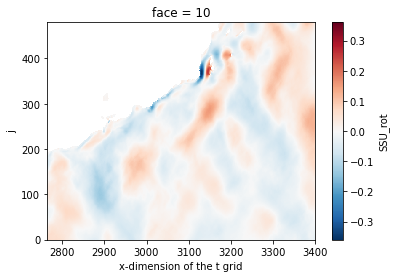

In [100]:
ds_mean.SSU_rot.plot()

In [36]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
